<H2> Проект: Маркетинговый анализ данных Яндекс.Афиши с июня 2017 по конец мая 2018 года с целью выявления невыгодных источников трафика, отказа от них и перераспределение бюджета.</H2>

Ответить на вопросы бизнеса:
* как клиенты пользуются сервисом,
* когда делают первые покупки на сайте,
* сколько денег приносит компании каждый клиент,
* когда расходы на привлечение клиента окупаются.

Выручка измеряется в условных единицах — у.е.

###### Содержание:
[1. Получение данных, изучение информации, подготовка данных.](##step1) 


[2. Рассчeт метрик и построение графиков.](##step2)

-  [2.1. Продуктовые метрики.](##step2.1)

-  [2.2. Метрики электронной коммерции.](##step2.2)

-  [2.3. Маркетинговые метрики.](##step2.3)

[3. Выводы и рекомендации.](##step3)

 <a id='#step1'></a>
<b>1. Получение данных, изучение информации, подготовка данных. </b>

In [1]:
#загрузим библиотеки

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import math as mt
from scipy import stats as st
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
from matplotlib import pyplot as plt
from math import factorial
from scipy.stats import norm
from matplotlib.pyplot import figure
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,6)
pd.options.mode.chained_assignment = None

In [2]:
#прочтем файлы в цикле и сохраним данные в переменных

visits = pd.read_csv('/datasets/visits_log.csv')#, sep="\t")
orders = pd.read_csv('/datasets/orders_log.csv')
expenses = pd.read_csv('/datasets/costs.csv')

def table_info():
    for table in [visits, orders, expenses]:
        print(table.info())
        print(table.head(2))
        print('______________________________________________________________')

table_info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
None
    Device               End Ts  Source Id             Start Ts  \
0    touch  2017-12-20 17:38:00          4  2017-12-20 17:20:00   
1  desktop  2018-02-19 17:21:00          2  2018-02-19 16:53:00   

                    Uid  
0  16879256277535980062  
1    104060357244891740  
______________________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
None
                Buy Ts  R

Из данных делаем следующие выводы:

1) во всех трех таблицах отсутствуют пропуски, заполнение не требуется

2) изменим наименования столбцов - приведем все к нижнему регистру, убрем пробелы и переименуем некоторые для ясности

3) необходимо заменить тип данных с Float на Date во всех таблицах, и столбцы u_id привести к object

In [3]:
#переименование столбцов

visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'u_id']
orders.columns = ['buy_ts','revenue','u_id']
expenses.columns = ['source_id', 'date', 'exp']

In [4]:
#функция для замены типа

def change_type(table, col_name):
    table[col_name] = pd.to_datetime(table[col_name], format = '%Y-%m-%d %H:%M:%S')

In [5]:
#меняем тип столбцов с датой
change_type(visits, 'end_ts')
change_type(visits, 'start_ts')
change_type(orders, 'buy_ts')
change_type(expenses, 'date')

#меняем тип в столбцах юзер
visits['u_id'] = visits['u_id'].astype(object)
orders['u_id'] = orders['u_id'].astype(object)

In [6]:
#проверим дубликаты в таблицах:
print(visits.duplicated().sum())
print(orders.duplicated().sum())
print(expenses.duplicated().sum())

0
0
0


In [7]:
#проверим соблюдена ли логика в данных: начало сессии раньше конца и выручка больше нуля
visits['check_ts'] = (visits['end_ts'] - visits['start_ts'])#.dt.seconds
visits['check_ts'].describe()

count                    359400
mean     0 days 00:10:43.025687
std      0 days 00:16:37.127760
min           -1 days +23:14:00
25%             0 days 00:02:00
50%             0 days 00:05:00
75%             0 days 00:14:00
max             0 days 11:51:00
Name: check_ts, dtype: object

In [8]:
visits.sort_values('check_ts').head()
#.info()

,device,end_ts,source_id,start_ts,u_id,check_ts
177972,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453,-1 days +23:14:00
4181,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986,-1 days +23:28:00
141593,desktop,2018-01-25 20:55:00,4,2018-01-25 20:55:00,6885023040148462867,00:00:00
251174,desktop,2018-02-08 15:35:00,3,2018-02-08 15:35:00,6843418812504165819,00:00:00
70748,desktop,2018-02-28 16:18:00,2,2018-02-28 16:18:00,4903558401822217411,00:00:00


In [9]:
visits=visits[visits['check_ts'] >= '00:00:00']

In [10]:
visits['check_ts'].describe()

count                    359398
mean     0 days 00:10:43.042287
std      0 days 00:16:37.105211
min             0 days 00:00:00
25%             0 days 00:02:00
50%             0 days 00:05:00
75%             0 days 00:14:00
max             0 days 11:51:00
Name: check_ts, dtype: object

In [11]:
#проверим везде ли выручка больше нуля
orders=orders[orders['revenue'] >0]
orders['revenue'].describe()

count    50364.000000
mean         5.004710
std         21.828823
min          0.010000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

<a id='#step2'></a>
<b> 2. Расчет метрик и построение графиков.</b>

<a id='#step2.1'></a>
<b> 2.1. Продуктовые метрики. </b>

<b> 2.1.1. Рассчитаем DAU, WAU, MAU - количество уникальных пользователей в день, неделю и месяц, посмотрим их средние значения за весь период и отобразим на графиках изменения этих параметров во времени

In [12]:
visits['s_year']  = visits['start_ts'].dt.year
visits['s_month'] = visits['start_ts'].dt.month
visits['s_week']  = visits['start_ts'].dt.week
visits['s_date'] = visits['start_ts'].dt.date
visits.head(2)

,device,end_ts,source_id,start_ts,u_id,check_ts,s_year,s_month,s_week,s_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,00:18:00,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,00:28:00,2018,2,8,2018-02-19


In [13]:
#2.1.1. Рассчитайте DAU, WAU и MAU

dau = visits.groupby('s_date').agg({'u_id': 'nunique'}).mean()
wau = visits.groupby(['s_year', 's_week']).agg({'u_id': 'nunique'}).mean()
mau = visits.groupby(['s_year', 's_month']).agg({'u_id': 'nunique'}).mean()
print('DAU = ',int(dau))
print('----------------')
print('WAU = ',int(wau))
print('----------------')
print('MAU = ',int(mau))

DAU =  907
----------------
WAU =  5716
----------------
MAU =  23228


In [14]:
def graf_dwm(col1,col2,x_text, y_text,name):
    visits.groupby([col1,col2]).agg({'u_id': 'nunique'}).plot(kind='line', style = '-', y='u_id', grid=True, figsize=(12, 5))
    plt.xticks(rotation=90)
    plt.xlabel(x_text)
    plt.ylabel(y_text)
    plt.title(name)
    plt.show()

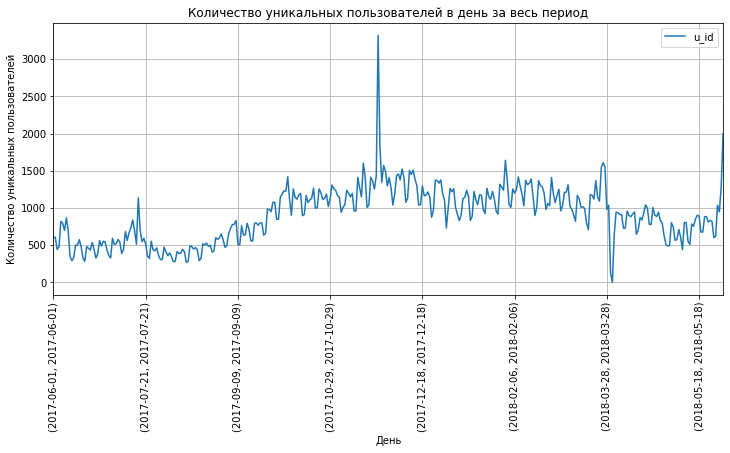

In [15]:
graf_dwm('s_date','s_date','День', 'Количество уникальных пользователей','Количество уникальных пользователей в день за весь период')

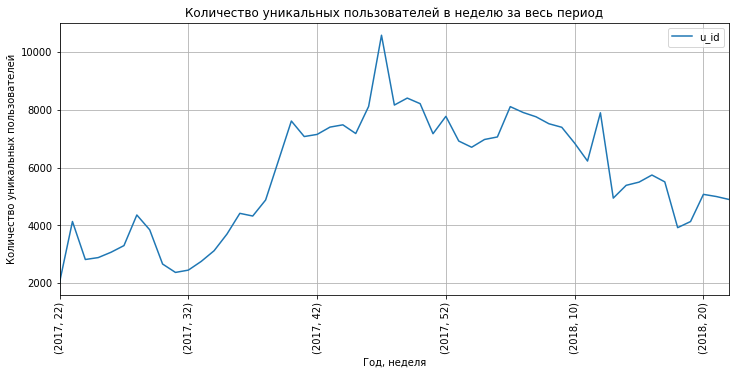

In [16]:
graf_dwm('s_year', 's_week','Год, неделя', 'Количество уникальных пользователей','Количество уникальных пользователей в неделю за весь период')
wau = visits.groupby(['s_year', 's_week']).agg({'u_id': 'nunique'}).mean()

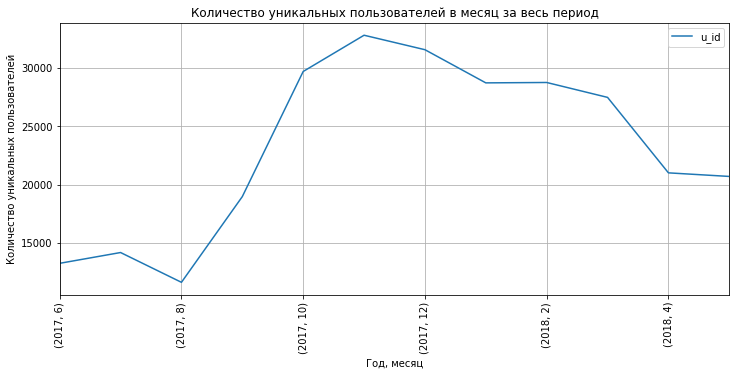

In [17]:
graf_dwm('s_year', 's_month','Год, месяц', 'Количество уникальных пользователей','Количество уникальных пользователей в месяц за весь период')

<b> 2.1.2. Cколько раз за день пользователи в среднем заходят на сайт и как изменяется эта метрика с течением времени?

In [18]:
#сгрупируем по дню захода и посчитаем уникальных пользователей
ses_per_user = visits.groupby('s_date').agg({'u_id': ['count','nunique']}).reset_index()
ses_per_user.head(2)

s_date  u_id        
              count nunique
0  2017-06-01   664     605
1  2017-06-02   658     608

In [19]:
#переименуем столбцы
ses_per_user.columns = ['s_date', 'user_count', 'user_unique']

In [20]:
#посчитаем среднее по количеству всех сессий за день и уникальных 
print("Количество сессий в день {0:.2f} ".format(ses_per_user['user_count'].mean()))
print("Количество уникальных сессий в день {0:.2f} ".format(ses_per_user['user_unique'].mean()))

Количество сессий в день 987.36 
Количество уникальных сессий в день 907.99 


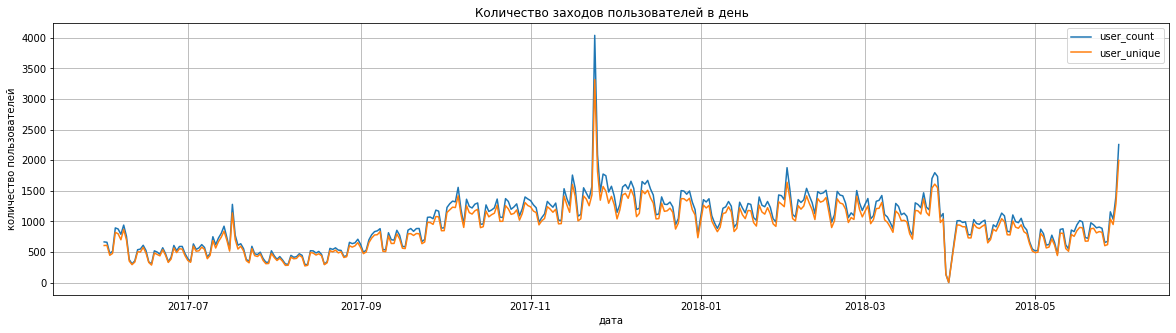

In [21]:
#посмотрим как распределены сессии во времени
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(ses_per_user['s_date'],ses_per_user['user_count'], label = 'user_count')
ax.plot(ses_per_user['s_date'],ses_per_user['user_unique'], label = 'user_unique')
plt.title('Количество заходов пользователей в день')
plt.ylabel('количество пользователей')
plt.xlabel('дата')
ax.legend()
ax.grid()
plt.show()

<b> 2.1.3. Cколько времени пользователи проводят на сайте?  Посчитаем среднюю продолжительность пользовательской сессии за весь период и проверим как она распределена по пользователям.

In [22]:
#расчитаем среднюю продолжительность сессии
visits['s_duration'] = (visits['end_ts']-visits['start_ts']).dt.seconds
print("Средняя продолжительность пользовательсской сессии =", int(visits['s_duration'].mean()), 'сек.')

Средняя продолжительность пользовательсской сессии = 643 сек.


In [23]:
#также оценим продолжительность методом describe
visits['s_duration'].describe()

count    359398.000000
mean        643.042287
std         997.105212
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       42660.000000
Name: s_duration, dtype: float64

In [24]:
# также оценим модное время
visits['s_duration'].mode()

0    60
dtype: int64

In [25]:
ses_per_user_duration = visits.groupby('u_id').agg({'s_duration': ['sum','mean']}).reset_index()
ses_per_user_duration.columns = ['u_id', 'sum_duration', 'mean_duration']
ses_per_user_duration.head(2)

,u_id,sum_duration,mean_duration
0,11863502262781,360,360.0
1,49537067089222,120,120.0


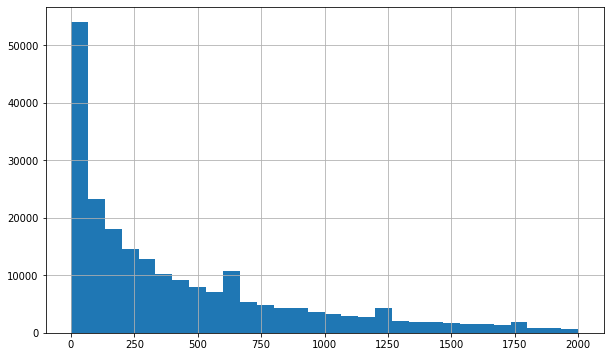

In [26]:
ses_per_user_duration['mean_duration'].hist(bins=30, range = (0,2000));

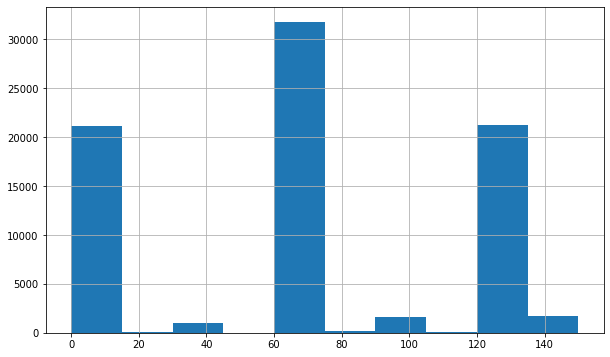

In [27]:
#посмотрим более детально интервал до 150 сек
ses_per_user_duration['mean_duration'].hist(bins=10, range = (0,150));

Интересно, какое количество пользователей заходят лишь один раз?

In [28]:
#data = data[data['selected_city'].isin(data['Charge_Point_City'])]
ses_per_user_duration2 = ses_per_user_duration[ses_per_user_duration['sum_duration'].isin(ses_per_user_duration['mean_duration'])]
print('Из', len(visits), 'пользователей', len(ses_per_user_duration2), 'заходят только 1 раз')

Из 359398 пользователей 226210 заходят только 1 раз


<b> 2.1.4. Рассчет Retention Rate с применением когортного анализа.

In [29]:
#найдем дату первой активности, сохраним в отдельную серию и соединим с основной таблицей визитов
first_visit = visits.groupby(['u_id'])['s_date'].min()
first_visit.name = 'first_visit'
visits = visits.join(first_visit, on='u_id')

In [30]:
#сделаем расчет по кагортам по месяцам
visits['first_visit_month'] = visits['first_visit'].astype('datetime64[M]')
visits['visit_month'] = visits['start_ts'].astype('datetime64[M]')
visits['lifetime'] = (visits['visit_month'] - visits['first_visit_month']) / np.timedelta64(1, 'M')
visits['lifetime'] = visits['lifetime'].round().astype('int')

cohort_visits = visits.groupby(['first_visit_month', 'lifetime']).agg({'u_id': 'nunique'}).reset_index()
first_u_id = cohort_visits[cohort_visits['lifetime'] == 0][['first_visit_month', 'u_id']]
first_u_id.columns = ['first_visit_month', 'first_u_id']

cohort_visits = cohort_visits.merge(first_u_id)
cohort_visits['retention'] = cohort_visits['u_id'] / cohort_visits['first_u_id']
visits_retention_pivot = cohort_visits.pivot_table(index = 'first_visit_month', 
                                                   columns = 'lifetime', values = 'retention', aggfunc = 'sum')

visits_retention_pivot.mean() * 100
visits_retention_pivot.head(2)

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_visit_month,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN


In [31]:
visits_retention_pivot.loc['mean'] = visits_retention_pivot.mean()
visits_retention_pivot.tail(3)

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_visit_month,,,,,,,,,,,,
2018-04-01 00:00:00,1.0,0.048380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-01 00:00:00,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.0,0.065167,0.046333,0.04276,0.040595,0.039444,0.036957,0.037509,0.035465,0.035159,0.034062,0.044951


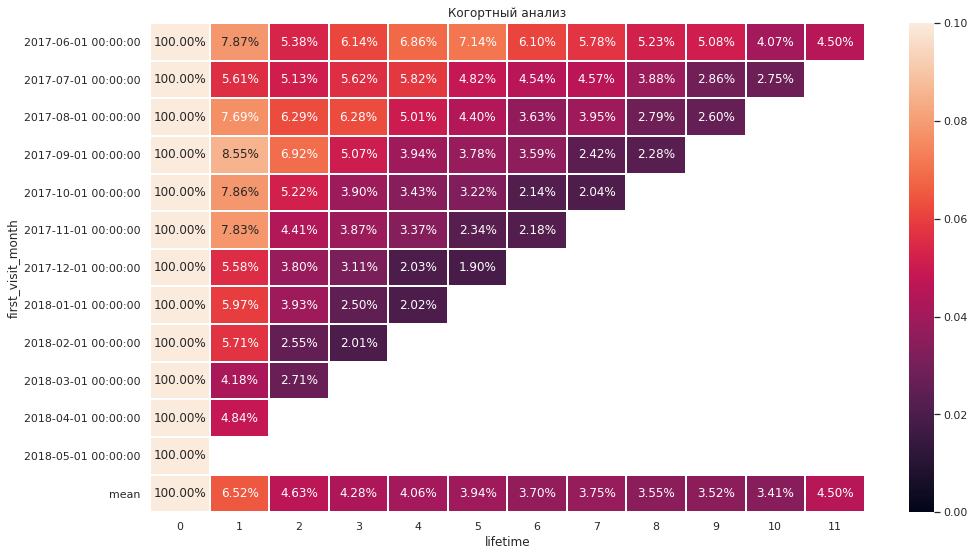

In [32]:
#построим тепловую карту по свдной таблице для наглядности
sns.set(style = 'whitegrid')
plt.figure(figsize = (16, 9))
plt.title('Когортный анализ')
ax = sns.heatmap(visits_retention_pivot, annot=True, fmt='.2%', linewidths=1, linecolor='white', vmin=0, vmax=0.1)
plt.show()

<b> Вывод


<b> 2.1. Метрики электронной коммерции. <a id='#step2.2'></a>

<b> 2.2.1. Посчитаем сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки

In [33]:
orders.head(2)

,buy_ts,revenue,u_id
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447


In [34]:
visits.head(2)

,device,end_ts,source_id,start_ts,u_id,check_ts,s_year,s_month,s_week,s_date,s_duration,first_visit,first_visit_month,visit_month,lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,00:18:00,2017,12,51,2017-12-20,1080,2017-12-20,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,00:28:00,2018,2,8,2018-02-19,1680,2018-02-19,2018-02-01,2018-02-01,0


In [35]:
# сгруппируем каждую таблицу по пользователям и вычислим время первого визита и первой покупки, объединим и найдем время до первой покупки
f_visit = visits.groupby('u_id').agg({'start_ts':'min'})\
        .rename(columns={'start_ts':'f_visit_date'}).reset_index()

f_order = orders.groupby('u_id').agg({'buy_ts':'min'})\
        .rename(columns={'buy_ts':'f_order_date'}).reset_index()

order_time = f_visit.merge(f_order, on='u_id', how='inner')
order_time['time_to_buy'] = (order_time['f_order_date'] - order_time['f_visit_date']).dt.seconds/60

#исключим строки с нулями
order_time= order_time[order_time['time_to_buy']!=0]

order_time.head()

,u_id,f_visit_date,f_order_date,time_to_buy
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,1382.0
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,79.0
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00,1184.0
5,3077748354309989,2018-03-03 12:08:00,2018-03-03 12:33:00,25.0
6,3605148382144603,2017-08-15 21:54:00,2017-09-21 20:56:00,1382.0


In [36]:
order_time['time_to_buy'].describe()

count    34046.000000
mean       267.245668
std        439.598745
min          1.000000
25%          5.000000
50%         20.000000
75%        310.000000
max       1439.000000
Name: time_to_buy, dtype: float64

In [37]:
order_time['time_to_buy'].mode()

0    1.0
dtype: float64

In [38]:
#сoздадим функцию для построения гистограммы
def order_times(x):
    order_time['time_to_buy'].hist(range=(0,x), bins=100);
    ax.set_xlabel('Время в минутах')
    ax.set_ylabel('Частота')
    ax.set_title('Время в минутах от первого визита до покупки')

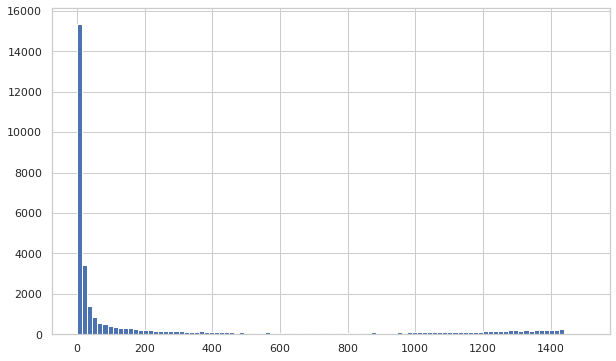

In [39]:
order_times(1500)

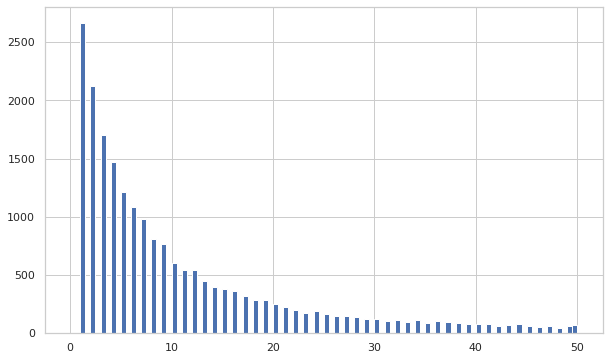

In [40]:
order_times(50)

Вывод:
    Когда люди начинают покупать:

<b> 2.2.2. Применяя когортный анализ, рассчитайте среднее количество покупок на одного клиента за определённый период, например за 6 месяцев

In [41]:
orders.head(2)

,buy_ts,revenue,u_id
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447


In [42]:
#добавим столбцы, найдем количество первых покупателей для каждого месяца
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')

first_order = orders.groupby('u_id').agg({'order_month':'min'}).reset_index()
first_order.columns = ['u_id', 'first_order_month']
orders = orders.merge(first_order, on='u_id', how='inner')

In [43]:
orders.head(2)

,buy_ts,revenue,u_id,order_month,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01


In [44]:
#найдем количество первых покупателей для каждого месяца 
cohort_sizes = first_order.groupby('first_order_month').agg({'u_id':'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
orders_first_month= orders.merge(cohort_sizes, on = 'first_order_month', how='inner')
orders_first_month.head(2)

,buy_ts,revenue,u_id,order_month,first_order_month,n_buyers
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2022
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2022


In [45]:
cohorts = orders_first_month.groupby(['first_order_month', 'order_month'])\
            .agg({'revenue':['sum','count']}).reset_index()
cohorts.columns = ['first_order_month','order_month','sum_rev','count_rev']
cohorts.head(2)

,first_order_month,order_month,sum_rev,count_rev
0,2017-06-01,2017-06-01,9557.49,2353
1,2017-06-01,2017-07-01,981.82,177


In [46]:
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

In [47]:
report.head(2)

,first_order_month,n_buyers,order_month,sum_rev,count_rev
0,2017-06-01,2022,2017-06-01,9557.49,2353
1,2017-06-01,2022,2017-07-01,981.82,177


In [48]:
#добавим возраст когорты 
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report.head(2)

,first_order_month,n_buyers,order_month,sum_rev,count_rev,age
0,2017-06-01,2022,2017-06-01,9557.49,2353,0
1,2017-06-01,2022,2017-07-01,981.82,177,1


In [49]:
#посчитаем количество покупок на одного клиента
report['order_per_buyer'] = report['count_rev']/report['n_buyers']
report.head(2)

,first_order_month,n_buyers,order_month,sum_rev,count_rev,age,order_per_buyer
0,2017-06-01,2022,2017-06-01,9557.49,2353,0,1.163699
1,2017-06-01,2022,2017-07-01,981.82,177,1,0.087537


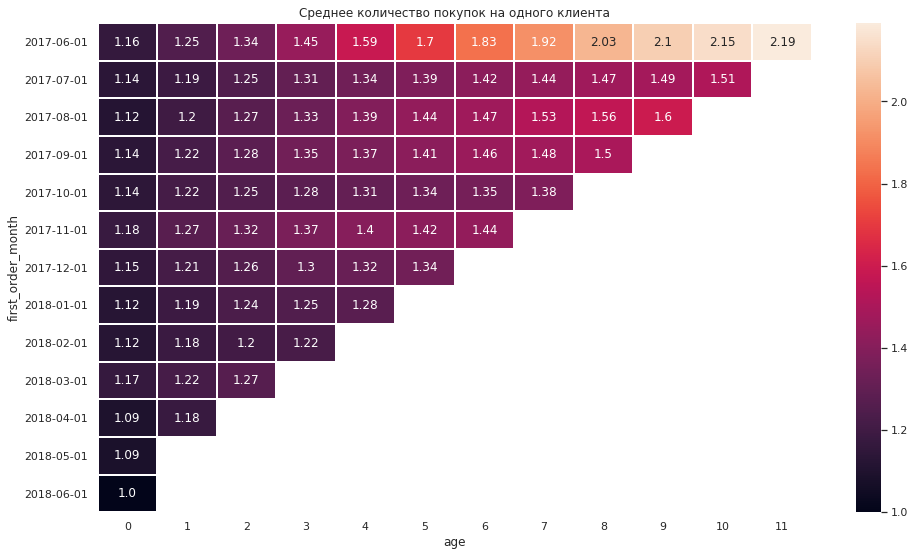

In [50]:
#построим сводную таблицу количества покупок на одного клиента и отобразим на тепловой карте
pivot_report = report.pivot_table(
                index= 'first_order_month',
                columns = 'age',
                values = 'order_per_buyer',
                aggfunc = 'sum')
pivot_report=pivot_report.cumsum(axis=1)

sns.set(style = 'whitegrid')
plt.figure(figsize = (16, 9))
plt.title('Cреднее количество покупок на одного клиента')
ax = sns.heatmap(pivot_report, annot=True, fmt='.3', linewidths=1, linecolor='white')
ax.set_yticklabels(pivot_report.index.date)
plt.show()

In [51]:
print('Среднее количество покупок для кагорт от 6 месяцев:')
print("")
print(pivot_report[:7][5].round(2))

Среднее количество покупок для кагорт от 6 месяцев:

first_order_month
2017-06-01    1.70
2017-07-01    1.39
2017-08-01    1.44
2017-09-01    1.41
2017-10-01    1.34
2017-11-01    1.42
2017-12-01    1.34
Name: 5, dtype: float64


<b> 2.2.3. Рассчитаем среднюю выручку с пользователя и покажем как она меняется с течением времени.

In [52]:
#посмотрим распределения по выручке
orders['revenue'].describe()

count    50364.000000
mean         5.004710
std         21.828823
min          0.010000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

In [53]:
#посмотрим модное распределение
orders['revenue'].mode()

0    1.83
dtype: float64

In [54]:
orders.head(2)

,buy_ts,revenue,u_id,order_month,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01


In [55]:
#найдем месяц заказа и первого заказа
orders['f_order_month'] = pd.DatetimeIndex(orders['first_order_month']).month
orders['o_month'] = pd.DatetimeIndex(orders['order_month']).month

In [56]:
#построим сводную таблицу по выручке по месяцам
pivot_av_rev = orders.pivot_table(
                index= ['f_order_month','o_month'],
                values = 'revenue',
                aggfunc = 'sum').reset_index()
pivot_av_rev['revenue']=pivot_av_rev['revenue'].round(2)
pivot_av_rev.head(5)

,f_order_month,o_month,revenue
0,1,1,13949.50
1,1,2,994.22
2,1,3,1026.34
3,1,4,481.59
4,1,5,211.48


In [57]:
#найдем среднюю выручку с пользователя по месяцам
av_revenue = orders.groupby('order_month').agg({'revenue': 'sum', 'u_id':'nunique'}).reset_index()
av_revenue['av_per_month'] = av_revenue['revenue']/av_revenue['u_id']
av_revenue

,order_month,revenue,u_id,av_per_month
0,2017-06-01,9557.49,2022,4.726751
1,2017-07-01,12539.47,1983,6.323485
2,2017-08-01,8758.78,1471,5.954303
3,2017-09-01,18345.51,2748,6.675950
4,2017-10-01,27987.70,4673,5.989236
5,2017-11-01,27069.93,4543,5.958602
6,2017-12-01,36388.60,4937,7.370589
7,2018-01-01,19417.13,3898,4.981306
8,2018-02-01,25560.54,4258,6.002945
9,2018-03-01,28834.59,4181,6.896577


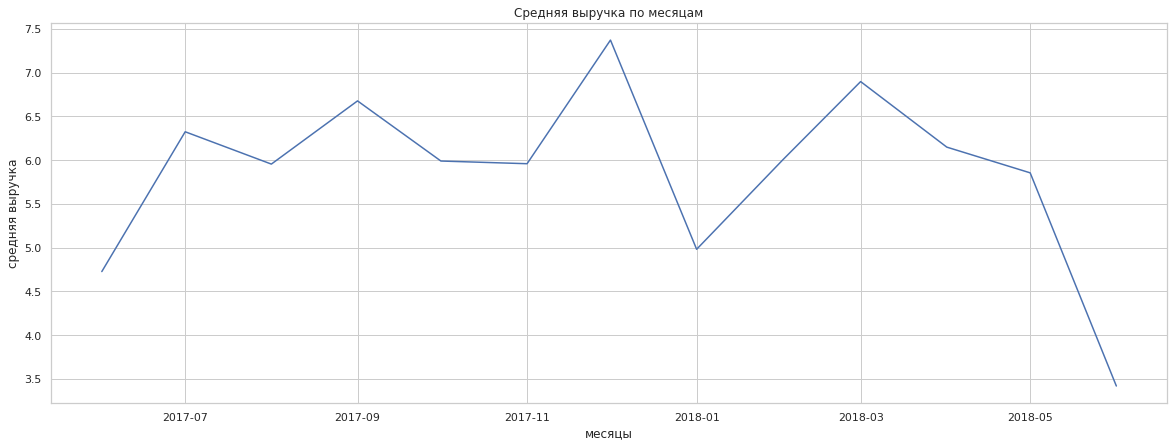

In [58]:
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(av_revenue['order_month'],av_revenue['av_per_month'], label = 'средняя выручка')
plt.title('Средняя выручка по месяцам')
plt.ylabel('средняя выручка')
plt.xlabel('месяцы')
ax.grid(True)
plt.show()

In [59]:
print('Минимальная средняя выручка = ',av_revenue['av_per_month'].min().round(2))
print('Максимальная средняя выручка =',av_revenue['av_per_month'].max().round(2))
print('Cредняя выручка =',av_revenue['av_per_month'].mean().round(2))
print('Медианная выручка =',av_revenue['av_per_month'].median().round(2))
#print('Медианная выручка =',av_revenue['av_per_month'].mode().round(2))

Минимальная средняя выручка =  3.42
Максимальная средняя выручка = 7.37
Cредняя выручка = 5.87
Медианная выручка = 5.99


<b> 2.2.4. Выясним как меняется во времени накопительный LTV по когортам. Сравним средний LTV по когортам за 6 месяцев. Оценим когорты, «прожившие» не менее 6 месяцев. Примем маржинальность сервиса — 100%.

In [60]:
orders.head(2)

,buy_ts,revenue,u_id,order_month,first_order_month,f_order_month,o_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,6,6
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,6,6


In [61]:
#посчитаем количество новых покупателей за каждый месяц
cohort_sizes = orders.groupby('first_order_month').agg({'u_id':'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month','n_buyers']
cohort_sizes.head(2)

,first_order_month,n_buyers
0,2017-06-01,2022
1,2017-07-01,1922


In [62]:
#сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку
cohorts = orders.groupby(['first_order_month', 'order_month'])\
            .agg({'revenue':'sum'}).reset_index()
cohorts.head(2)

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82


In [63]:
#объединим таблицы
report = pd.merge(cohorts,cohort_sizes, on='first_order_month')
report.head(2)

,first_order_month,order_month,revenue,n_buyers
0,2017-06-01,2017-06-01,9557.49,2022
1,2017-06-01,2017-07-01,981.82,2022


In [64]:
#найдем возрасты кагорт
report['age'] = (report['order_month']-report['first_order_month'])/np.timedelta64(1,'M')
report['age'] = report['age'].round().astype('int')
report.head(2)

,first_order_month,order_month,revenue,n_buyers,age
0,2017-06-01,2017-06-01,9557.49,2022,0
1,2017-06-01,2017-07-01,981.82,2022,1


In [65]:
#найдем LTV. Разделим валовую прибыль кагорт за каждый месяц на общее число пользователей в каждой кагорте.
report['ltv'] = (report['revenue']/report['n_buyers']).round(2)
report.head(2)

,first_order_month,order_month,revenue,n_buyers,age,ltv
0,2017-06-01,2017-06-01,9557.49,2022,0,4.73
1,2017-06-01,2017-07-01,981.82,2022,1,0.49


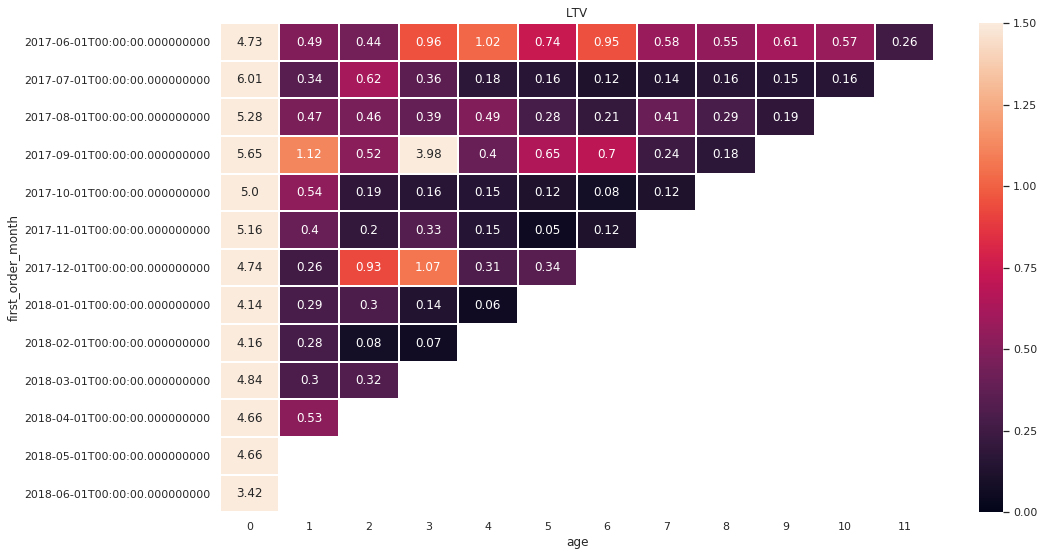

In [66]:
#построим сводную таблицу
pivot_report_1 = report.pivot_table(
                index= 'first_order_month',
                columns = 'age',
                values = 'ltv',
                aggfunc = 'mean')

sns.set(style = 'whitegrid')
plt.figure(figsize = (16, 9))
plt.title('LTV')
ax = sns.heatmap(pivot_report_1, annot=True, fmt='.3', linewidths=1, linecolor='white',vmin=0, vmax=1.5)
plt.show()

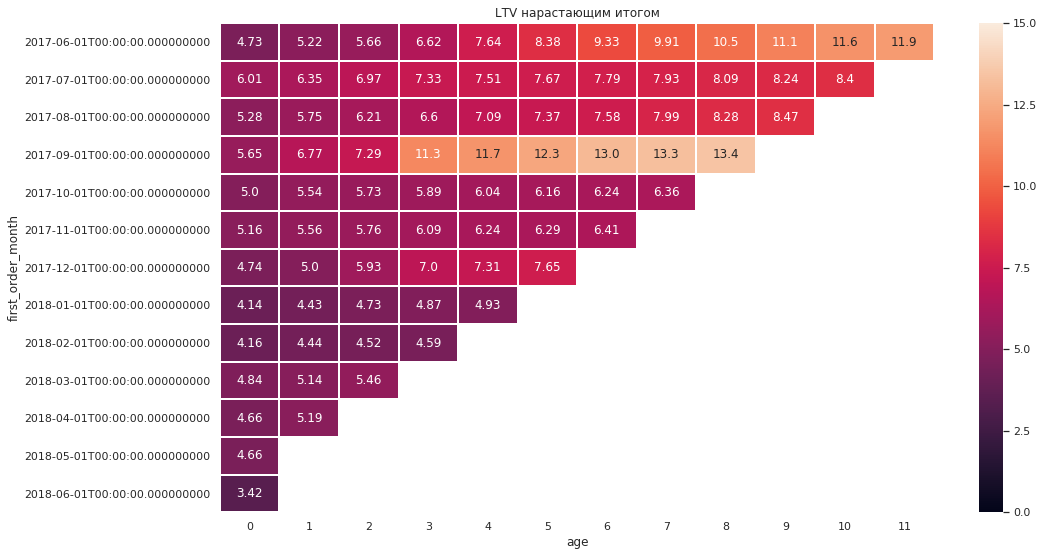

In [67]:
pivot_report_1.cumsum(axis=1)

sns.set(style = 'whitegrid')
plt.figure(figsize = (16, 9))
plt.title('LTV нарастающим итогом')
ax = sns.heatmap(pivot_report_1.cumsum(axis=1), annot=True, fmt='.3', linewidths=1, linecolor='white',vmin=0, vmax=15)
plt.show()

In [68]:
#средний LTV по всем кагортам отжившим от 6 месяцев
a= pivot_report_1[5].mean()
print('Средний LTV для всех кагорт старше 5 месяцев = ',a.round(2) )

Средний LTV для всех кагорт старше 5 месяцев =  0.33


<b> 2.3. Маркетинговые метрики. <a id='#step2.3'></a>

<b> 2.3.1. Посчитаем общую сумму расходов на маркетинг. Выясним как траты распределены по источникам и как меняется это распределение во времени.

In [69]:
expenses.head(2)

,source_id,date,exp
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25


In [70]:
print('Общая сумма расходов на маркетинг за весь вериод составляет ',expenses['exp'].sum().round(2))

Общая сумма расходов на маркетинг за весь вериод составляет  329131.62


In [71]:
expenses['date'] = expenses['date'].astype('datetime64[M]')
expenses.head(2)

,source_id,date,exp
0,1,2017-06-01,75.20
1,1,2017-06-01,62.25


In [72]:
#суммарные расходы по источнику и дате
exp_per_source = expenses.groupby(['source_id', 'date']).agg({'exp':'sum'}).reset_index()
exp_per_source.head()

,source_id,date,exp
0,1,2017-06-01,1125.61
1,1,2017-07-01,1072.88
2,1,2017-08-01,951.81
3,1,2017-09-01,1502.01
4,1,2017-10-01,2315.75


In [73]:
exp_per_source['exp_int']=exp_per_source['exp'].astype('int')
exp_per_source.head()

,source_id,date,exp,exp_int
0,1,2017-06-01,1125.61,1125
1,1,2017-07-01,1072.88,1072
2,1,2017-08-01,951.81,951
3,1,2017-09-01,1502.01,1502
4,1,2017-10-01,2315.75,2315


Text(0.5, 0, 'месяцы')

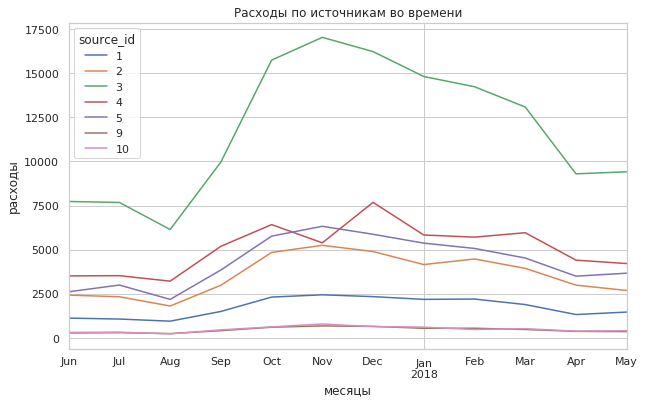

In [74]:
pivot_exp = exp_per_source.pivot_table(
                index= 'date',
                columns = 'source_id',
                values = 'exp_int',
                aggfunc = 'sum')

pivot_exp.plot();
plt.title('Расходы по источникам во времени')
plt.ylabel('pасходы')
plt.xlabel('месяцы')
#pivot_exp

<b> 2.3.2. Рассчитаем CAC. Определим сколько стоит привлечение одного покупателя из каждого источника трафика.

In [75]:
#найдем первое посещение каждого пользователя и узнаем из какого источника был переход и на каком девайсе просмотр
visits_source = visits.groupby(['u_id']).agg({'start_ts':'min', 'source_id':'first','device':'first'}).reset_index()
visits_source = visits_source[['u_id','start_ts','source_id','device']]
visits_source.head(2)

,u_id,start_ts,source_id,device
0,11863502262781,2018-03-01 17:27:00,3,touch
1,49537067089222,2018-02-06 15:55:00,2,touch


In [76]:
#объединим таблицы
source_buyers = pd.merge(visits_source,orders, on='u_id', how='inner')
source_buyers.head(2)

,u_id,start_ts,source_id,device,buy_ts,revenue,order_month,first_order_month,f_order_month,o_month
0,313578113262317,2017-09-18 22:49:00,2,desktop,2018-01-03 21:51:00,0.55,2018-01-01,2018-01-01,1,1
1,1575281904278712,2017-06-03 10:13:00,10,touch,2017-06-03 10:13:00,1.22,2017-06-01,2017-06-01,6,6


In [77]:
#с какого источника сколько пользователей и количество их покупок
source_buyers_group=source_buyers.groupby('source_id').agg({'u_id':'nunique', 'buy_ts':'count'}).reset_index()
source_buyers_group

,source_id,u_id,buy_ts
0,1,3740,6665
1,2,4320,7722
2,3,9134,10935
3,4,9822,12242
4,5,6838,9309
5,7,1,1
6,9,1415,2053
7,10,1239,1437


In [78]:
expenses.head(2)

,source_id,date,exp
0,1,2017-06-01,75.20
1,1,2017-06-01,62.25


In [79]:
exp_per_source_cac = exp_per_source.groupby('source_id')['exp'].sum()
exp_per_source_cac

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: exp, dtype: float64

In [80]:
#добавим расходы по источникам к покупателям по источникам для дальнейшего расчета сас
cac = source_buyers_group.join(exp_per_source_cac, on='source_id')
cac

,source_id,u_id,buy_ts,exp
0,1,3740,6665,20833.27
1,2,4320,7722,42806.04
2,3,9134,10935,141321.63
3,4,9822,12242,61073.60
4,5,6838,9309,51757.10
5,7,1,1,NaN
6,9,1415,2053,5517.49
7,10,1239,1437,5822.49


In [81]:
cac['cac'] = cac['exp']/cac['u_id']
print(cac.sort_values('cac', ascending=False))

   source_id  u_id  buy_ts        exp        cac
2          3  9134   10935  141321.63  15.472042
1          2  4320    7722   42806.04   9.908806
4          5  6838    9309   51757.10   7.569041
3          4  9822   12242   61073.60   6.218041
0          1  3740    6665   20833.27   5.570393
7         10  1239    1437    5822.49   4.699346
6          9  1415    2053    5517.49   3.899286
5          7     1       1        NaN        NaN


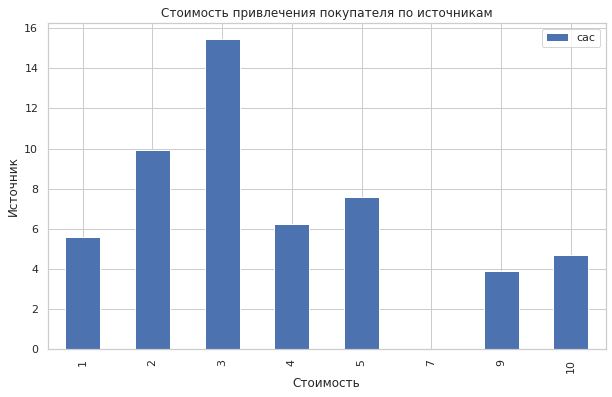

In [82]:
cac.plot(kind='bar', y='cac', x='source_id');
plt.title('Стоимость привлечения покупателя по источникам')
plt.ylabel('Источник')
plt.xlabel('Стоимость')
ax.grid(True)
plt.show()

<b> 2.3.3. Рассчитаем ROMI по когортам в разрезе источников. Сравним окупаемость за одинаковые периоды жизни когорт.

In [83]:
visits.head(2)

,device,end_ts,source_id,start_ts,u_id,check_ts,s_year,s_month,s_week,s_date,s_duration,first_visit,first_visit_month,visit_month,lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,00:18:00,2017,12,51,2017-12-20,1080,2017-12-20,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,00:28:00,2018,2,8,2018-02-19,1680,2018-02-19,2018-02-01,2018-02-01,0


In [84]:
#сгруппируем по пользователям и найдем время первой сессии и его источник
visits_new = visits.groupby(['u_id']).agg({'start_ts':'min', 'source_id':'first'}).reset_index()
visits_new.head(2)

,u_id,start_ts,source_id
0,11863502262781,2018-03-01 17:27:00,3
1,49537067089222,2018-02-06 15:55:00,2


In [85]:
#объединим таблицы
orders_new = pd.merge(orders, visits_new,  on='u_id')

In [86]:
orders_new.head(2)

,buy_ts,revenue,u_id,order_month,first_order_month,f_order_month,o_month,start_ts,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,6,6,2017-06-01 00:09:00,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,6,6,2017-06-01 00:14:00,2


In [87]:
#посчитаем количество новых покупателей за каждый месяц с каждого источника
cohort_sizes_s = orders_new.groupby(['source_id','first_order_month']).agg({'u_id':'nunique'}).reset_index()
cohort_sizes_s.columns = ['source_id','first_order_month','n_buyers']
cohort_sizes_s.head(2)

,source_id,first_order_month,n_buyers
0,1,2017-06-01,202
1,1,2017-07-01,211


In [88]:
#сгруппируем таблицу заказов по источнику, месяцу и месяцу первого заказа и сложим выручку
cohorts_s = orders_new.groupby(['source_id','first_order_month', 'order_month'])\
            .agg({'revenue':'sum'}).reset_index()
cohorts_s.head(2)

,source_id,first_order_month,order_month,revenue
0,1,2017-06-01,2017-06-01,1168.45
1,1,2017-06-01,2017-07-01,362.94


In [89]:
#объединим таблицы
report_s = pd.merge(cohorts_s,cohort_sizes_s, on=['source_id','first_order_month'])

In [90]:
report_s.head(2)

,source_id,first_order_month,order_month,revenue,n_buyers
0,1,2017-06-01,2017-06-01,1168.45,202
1,1,2017-06-01,2017-07-01,362.94,202


In [91]:
#найдем возрасты кагорт
report_s['age'] = (report_s['order_month']-report_s['first_order_month'])/np.timedelta64(1,'M')
report_s['age'] = report_s['age'].round().astype('int')
report_s.head(2)

,source_id,first_order_month,order_month,revenue,n_buyers,age
0,1,2017-06-01,2017-06-01,1168.45,202,0
1,1,2017-06-01,2017-07-01,362.94,202,1


In [92]:
#найдем LTV. Разделим валовую прибыль кагорт за каждый месяц на общее число пользователей в каждой кагорте.
report_s['ltv'] = (report_s['revenue']/report_s['n_buyers']).round(2)
report_s.head()

,source_id,first_order_month,order_month,revenue,n_buyers,age,ltv
0,1,2017-06-01,2017-06-01,1168.45,202,0,5.78
1,1,2017-06-01,2017-07-01,362.94,202,1,1.80
2,1,2017-06-01,2017-08-01,153.72,202,2,0.76
3,1,2017-06-01,2017-09-01,695.88,202,3,3.44
4,1,2017-06-01,2017-10-01,760.74,202,4,3.77


In [93]:
report_s_for_pivot = report_s.pivot_table(columns='age',
                                           index=['source_id','first_order_month'],
                                          values='ltv').\
    cumsum(axis=1).mean(axis=1).reset_index().groupby('source_id')[0].mean().reset_index()
report_s_for_pivot.rename(columns={0:'ltv'}, inplace=True)

In [94]:
report_s_for_pivot

,source_id,ltv
0,1,9.080636
1,2,11.636183
2,3,4.758326
3,4,5.113306
4,5,5.619633
5,7,1.220000
6,9,4.718966
7,10,3.336315


In [95]:
cac

,source_id,u_id,buy_ts,exp,cac
0,1,3740,6665,20833.27,5.570393
1,2,4320,7722,42806.04,9.908806
2,3,9134,10935,141321.63,15.472042
3,4,9822,12242,61073.60,6.218041
4,5,6838,9309,51757.10,7.569041
5,7,1,1,NaN,NaN
6,9,1415,2053,5517.49,3.899286
7,10,1239,1437,5822.49,4.699346


In [96]:
report_s_for_pivot_new = cac.merge(report_s_for_pivot, how='inner', on=['source_id'])
report_s_for_pivot_new

,source_id,u_id,buy_ts,exp,cac,ltv
0,1,3740,6665,20833.27,5.570393,9.080636
1,2,4320,7722,42806.04,9.908806,11.636183
2,3,9134,10935,141321.63,15.472042,4.758326
3,4,9822,12242,61073.60,6.218041,5.113306
4,5,6838,9309,51757.10,7.569041,5.619633
5,7,1,1,NaN,NaN,1.220000
6,9,1415,2053,5517.49,3.899286,4.718966
7,10,1239,1437,5822.49,4.699346,3.336315


In [97]:
report_s_for_pivot_new['romi'] = report_s_for_pivot_new['ltv']/report_s_for_pivot_new['cac']
report_s_for_pivot_new

,source_id,u_id,buy_ts,exp,cac,ltv,romi
0,1,3740,6665,20833.27,5.570393,9.080636,1.630161
1,2,4320,7722,42806.04,9.908806,11.636183,1.174327
2,3,9134,10935,141321.63,15.472042,4.758326,0.307543
3,4,9822,12242,61073.60,6.218041,5.113306,0.822334
4,5,6838,9309,51757.10,7.569041,5.619633,0.742450
5,7,1,1,NaN,NaN,1.220000,NaN
6,9,1415,2053,5517.49,3.899286,4.718966,1.210213
7,10,1239,1437,5822.49,4.699346,3.336315,0.709953


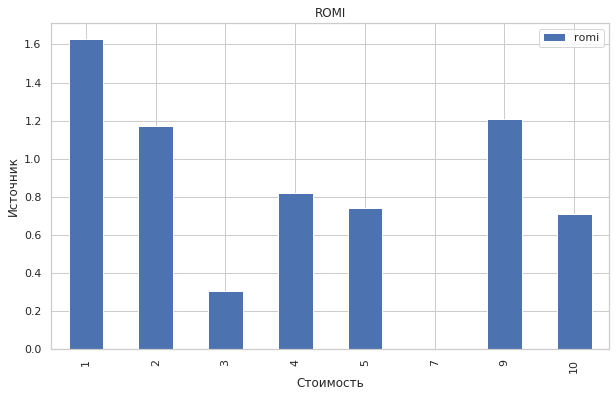

In [98]:
report_s_for_pivot_new.plot(kind='bar', y='romi', x='source_id');
plt.title('ROMI')
plt.ylabel('Источник')
plt.xlabel('Стоимость')
ax.grid(True)
plt.show()

<b> Проведем анализ по устройствам: </b>

1) рассчитаем с какого устройства заходят чаще всего

2) с какого наибольшее количество заказов

3) с какого наибольшая выручка

In [99]:
source_buyers.head()

,u_id,start_ts,source_id,device,buy_ts,revenue,order_month,first_order_month,f_order_month,o_month
0,313578113262317,2017-09-18 22:49:00,2,desktop,2018-01-03 21:51:00,0.55,2018-01-01,2018-01-01,1,1
1,1575281904278712,2017-06-03 10:13:00,10,touch,2017-06-03 10:13:00,1.22,2017-06-01,2017-06-01,6,6
2,1575281904278712,2017-06-03 10:13:00,10,touch,2017-06-03 17:39:00,1.83,2017-06-01,2017-06-01,6,6
3,2429014661409475,2017-10-11 17:14:00,3,desktop,2017-10-11 18:33:00,73.33,2017-10-01,2017-10-01,10,10
4,2464366381792757,2018-01-27 20:10:00,5,desktop,2018-01-28 15:54:00,2.44,2018-01-01,2018-01-01,1,1


In [100]:
amount_visitors = source_buyers.groupby('device').agg({'u_id':'nunique','start_ts':'count'})
amount_visitors['visits_per_u'] = amount_visitors['start_ts']/amount_visitors['u_id']
amount_visitors

,u_id,start_ts,visits_per_u
device,,,
desktop,29209,40855,1.398713
touch,7300,9509,1.302603


1) С компьютера заходят в 4 раза больше пользователей, однако количество визитов на пользователя с обоих устроиств почти одинаковое

In [101]:
amount_orders = source_buyers.groupby('device').agg({'revenue':['count','sum']}).reset_index()
amount_orders.columns = ['device','rev_count','rev_sum']
amount_orders['rev_per_order'] = amount_orders['rev_sum']/amount_orders['rev_count']
amount_orders

,device,rev_count,rev_sum,rev_per_order
0,desktop,40855,211531.81,5.177624
1,touch,9509,40525.39,4.261793


2 и 3) Количество заказов с компьютера выше в 4 раза (что логично, исходя из предыдущего пункта), чем в мобильной версии. При этом важно, что и средний чек с компьютера выше примерно на 20%. 

<b> 3. Вывод:</b>

Из расчетов делаю вывод, что самый высокий возврат на инвестиции у источника 1, затем следуют 9 и второй источники. Очевидно, что стоит сконцентрировать свои рекламные усилия именно на них и в такой последовательности. Самым дорогим и наименее прибыльным является источник 3. Источник 7 лучше проанализировать дополнительно.

Одна сессия длится: в среднем времени 10 минут, в медианном 5 минут, в модном 1 минуту.

Основная масса людей, около 90-95% не возвращаются за повторной покупкой, но те кто вернулся с высокой вероятностью покупают снова.

Люди начинают покупать в среднем времени через 267 минут, в медианном через 20 минут, в модном через 1 минуту. Другими словами, покупают чаще "сразу".

Среднее количество покупок на одного клиента в когортах, от 6 месяцев находится в диапазоне 1.7 - 1.34


Минимальная средняя выручка =  3.42
Максимальная средняя выручка = 7.37
Cредняя выручка = 5.87
Медианная выручка = 5.99

С десктопных устройств заходят чаще в 4 раза, и средний чек с них выше примерно но 20%.

Таким образом в первую очередь стоит сконцентрироваться на источнике 1 и клиентов, захдящих с компьютера.